# Import

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import numpy as np
import os
from datetime import datetime

import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline

# Création Dataset Sinus

In [23]:
# Paramètres du dataset
NUM_SAMPLES = 1000      # nombre d'exemples dans le dataset
SEQ_LEN = 64            # longueur de chaque série temporelle
BATCH_SIZE = 32
EPOCHS = 2000
LATENT_DIM = 16         # dimension du bruit pour le générateur

In [24]:
# On génère un dataset de sinusoïdes avec les mêmes fréquences, amplitudes et phases
def generate_sinus_data(num_samples=NUM_SAMPLES, seq_len=SEQ_LEN):
    data = []
    freq = np.random.uniform(0.5, 5.0)  # fréquence aléatoire
    phase = np.random.uniform(0, 2*np.pi)  # phase aléatoire
    for i in range(num_samples):
        amplitude = np.random.uniform(0.5, 1.5)  # amplitude aléatoire
        t = np.linspace(0, 2*np.pi, seq_len)
        signal = amplitude * np.sin(freq * t + phase)
        data.append(signal)
    data = np.array(data)
    return data

In [25]:
data = generate_sinus_data()

# Normalisation (par exemple, standardisation)
mean = data.mean()
std = data.std()
data = (data - mean) / (std + 1e-8)

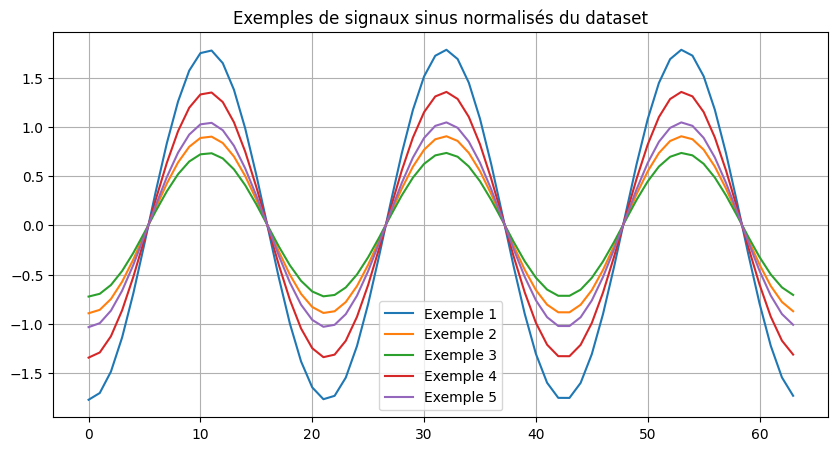

In [26]:
# Affichage de quelques exemples de sinusoïdes
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.plot(data[i], label=f'Exemple {i+1}')
plt.title("Exemples de signaux sinus normalisés du dataset")
plt.legend()
plt.grid()
plt.show()

# Dataset et DataLoader

In [27]:
class SinusDataset(Dataset):
    def __init__(self, data):
        self.data = data.astype(np.float32)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        x = self.data[idx]
        return torch.from_numpy(x)  # Conversion plus directe

In [28]:
dataset = SinusDataset(data)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

# TS-GAN avec Transformers

In [29]:
# On va créer un GAN avec un générateur et un discriminateur.
# Le générateur va prendre un bruit latent (batch, latent_dim) et générer un signal (batch, seq_len).
# Le discriminateur prend un signal (batch, seq_len) et renvoie une probabilité (réel ou faux).

# Cependant, on va insérer des Transformers:
# - Le générateur sera composé d'un transformeur decoder-only (ou encoder + linear) pour générer une séquence.
# - Le discriminateur sera un classifier transformer-based (par ex. encoder transformer) suivi d'une couche linéaire.

# Paramètres du transformeur
EMBED_DIM = 64
NHEAD = 4
NUM_LAYERS = 2
FFN_HIDDEN_DIM = 128

# Masque causal pour le générateur si on utilise un transformer decoder
def generate_square_subsequent_mask(sz: int):
    mask = torch.triu(torch.ones(sz, sz), 1)  # upper-triangular matrix of ones
    mask = mask.masked_fill(mask==1, float('-inf'))
    return mask

# Generateur

In [30]:
class Generator(nn.Module):
    def __init__(self, seq_len=SEQ_LEN, latent_dim=LATENT_DIM, emb_dim=EMBED_DIM, nhead=NHEAD, num_layers=NUM_LAYERS, ffn_hidden_dim=FFN_HIDDEN_DIM):
        super(Generator, self).__init__()
        
        self.seq_len = seq_len
        self.latent_dim = latent_dim
        self.embedding = nn.Linear(latent_dim, emb_dim)  # on transforme le bruit en embedding
        transformer_layer = nn.TransformerDecoderLayer(d_model=emb_dim, nhead=nhead, dim_feedforward=ffn_hidden_dim)
        self.transformer = nn.TransformerDecoder(transformer_layer, num_layers=num_layers)
        
        self.positional_encoding = self._build_positional_encoding(emb_dim, seq_len)
        self.output_linear = nn.Linear(emb_dim, 1)  # on sort 1 valeur par timestep
        self.register_buffer('tgt_mask', generate_square_subsequent_mask(seq_len))
        
    def _build_positional_encoding(self, d_model, max_len):
        # Positional encoding (classique)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[0::, 0, 0::2] = torch.sin(position * div_term)
        pe[0::, 0, 1::2] = torch.cos(position * div_term)
        return pe  # shape (max_len, 1, d_model)

    def forward(self, z):
        # z: (batch, latent_dim)
        batch_size = z.size(0)
        
        # On va répéter l'embedding sur la longueur de séquence, 
        # ou on peut simplement fournir un "début" vide et laisser le transformer "décoder".
        # Ici, on va considérer qu'on envoie un bruit répété sur seq_len steps.
        # Une autre approche : utiliser un embedding de shape (seq_len, batch, emb_dim)
        
        # Par simplicité, on va initialiser un token de départ qui sera le même pour tous,
        # puis le transformer decoder va générer la séquence.
        
        # Initialiser une entrée "cible" vide (juste du bruit broadcasté)
        # On part de vecteurs nuls comme target embeddings.
        tgt = torch.zeros(self.seq_len, batch_size, EMBED_DIM, device=z.device)  
        
        # Le state latent va être une clé/mémoire dans le decoder:
        # On va utiliser l'embedding du bruit comme "memory" (encodé)
        memory = self.embedding(z)  # (batch, emb_dim)
        # On reshape memory pour qu'il fasse (seq_len, batch, emb_dim) 
        # Ici on ne dispose pas vraiment d'une séquence en memory, 
        # on peut juste répéter ce vecteur sur un seul pas de temps ou plusieurs.
        # On va juste répéter le memory sur un pas de temps:
        memory = memory.unsqueeze(0)  # (1, batch, emb_dim)
        
        # Ajout du positional encoding sur la target
        tgt = tgt + self.positional_encoding.to(tgt.device)
        
        out = self.transformer(tgt, memory, tgt_mask=self.tgt_mask)
        # out: (seq_len, batch, emb_dim)
        
        # On projette sur une valeur par pas de temps
        out = self.output_linear(out)  # (seq_len, batch, 1)
        out = out.permute(1, 0, 2).squeeze(-1)  # (batch, seq_len)
        return out

# Discriminateur

In [31]:
class Discriminator(nn.Module):
    def __init__(self, seq_len=SEQ_LEN, emb_dim=EMBED_DIM, nhead=NHEAD, num_layers=NUM_LAYERS, ffn_hidden_dim=FFN_HIDDEN_DIM):
        super(Discriminator, self).__init__()
        
        self.seq_len = seq_len
        # Un transformer encoder pour classifier le signal comme réel ou faux
        encoder_layer = nn.TransformerEncoderLayer(d_model=emb_dim, nhead=nhead, dim_feedforward=ffn_hidden_dim)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        self.input_linear = nn.Linear(1, emb_dim)
        self.positional_encoding = self._build_positional_encoding(emb_dim, seq_len)
        self.output_linear = nn.Linear(emb_dim, 1)
        
    def _build_positional_encoding(self, d_model, max_len):
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[0::, 0, 0::2] = torch.sin(position * div_term)
        pe[0::, 0, 1::2] = torch.cos(position * div_term)
        return pe

    def forward(self, x):
        # x: (batch, seq_len)
        batch_size = x.size(0)
        x = x.unsqueeze(-1)  # (batch, seq_len, 1)
        x = self.input_linear(x)  # (batch, seq_len, emb_dim)
        x = x.permute(1, 0, 2)  # (seq_len, batch, emb_dim)
        
        x = x + self.positional_encoding.to(x.device)
        out = self.transformer(x)  # (seq_len, batch, emb_dim)
        
        # On pool en prenant le token moyen ou le dernier
        # Ici on va simplement prendre le premier token comme "classement"
        out = out[0, :, :]  # (batch, emb_dim)
        out = self.output_linear(out)  # (batch, 1)
        return out

# Initialisation

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on {device}")

Training on cuda


In [33]:
generator = Generator(seq_len=SEQ_LEN, latent_dim=LATENT_DIM).to(device)
discriminator = Discriminator(seq_len=SEQ_LEN).to(device)

/home/alex/.local/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [34]:
criterion = nn.BCEWithLogitsLoss()
optimizer_g = optim.Adam(generator.parameters(), lr=1e-4, betas=(0.5, 0.9))
optimizer_d = optim.Adam(discriminator.parameters(), lr=1e-4, betas=(0.5, 0.9))

In [35]:
def generate_noise(batch_size, latent_dim):
    return torch.randn(batch_size, latent_dim, device=device)

# Pour le tracking des Loss
G_losses = []
D_losses = []

In [36]:
# Obtenir la date et l'heure actuelles au format souhaité
current_time = datetime.now().strftime("%Y-%m-%d_%Hh%Mmin")

In [ ]:
# Créer un dossier pour sauvegarder les sinusoïdes générées avec la date, l'heure et la longueur de séquence
OUTPUT_DIR = f"generated/generated_sinus_same_freq_phase_seq_len_{SEQ_LEN}_{current_time}"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Boucle d'entraînement

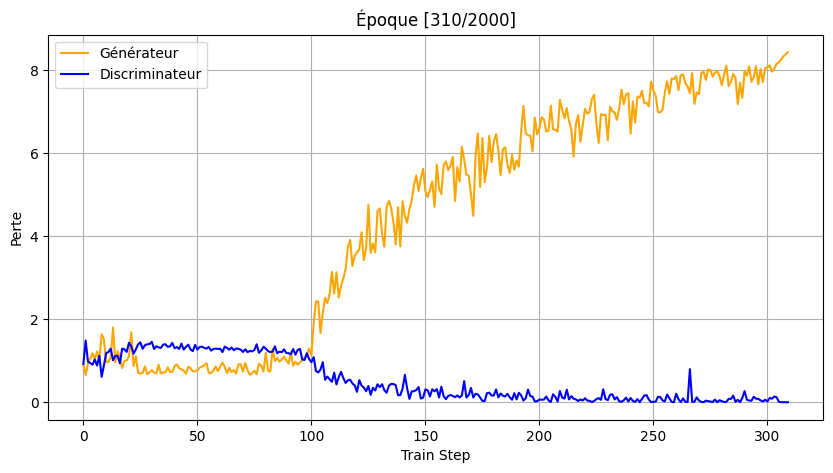

KeyboardInterrupt: 

In [38]:
for epoch in range(EPOCHS):
    for real_data in dataloader:
        real_data = real_data.to(device)  # (batch, seq_len)
        batch_size = real_data.size(0)
        
        # -----------------------
        # Train Discriminator
        # -----------------------
        optimizer_d.zero_grad()
        # Real
        real_label = torch.ones(batch_size, 1, device=device)
        fake_label = torch.zeros(batch_size, 1, device=device)
        
        real_output = discriminator(real_data)
        d_real_loss = criterion(real_output, real_label)
        
        # Fake
        z = generate_noise(batch_size, LATENT_DIM)
        fake_data = generator(z).detach()
        fake_output = discriminator(fake_data)
        d_fake_loss = criterion(fake_output, fake_label)
        
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        optimizer_d.step()
        
        # -----------------------
        # Train Generator
        # -----------------------
        optimizer_g.zero_grad()
        z = generate_noise(batch_size, LATENT_DIM)
        gen_data = generator(z)
        gen_output = discriminator(gen_data)
        g_loss = criterion(gen_output, real_label)
        g_loss.backward()
        optimizer_g.step()
        
    G_losses.append(g_loss.item())
    D_losses.append(d_loss.item())
    
    if (epoch+1) % 10 == 0:
        # print(f"Epoch [{epoch+1}/{EPOCHS}]  D_loss: {d_loss.item():.4f}  G_loss: {g_loss.item():.4f}")
    
        clear_output(wait=True)  # Efface le contenu précédent de la cellule
        
        # Affichage des pertes
        plt.figure(figsize=(10,5))
        plt.plot(G_losses, label="Générateur", color='orange')
        plt.plot(D_losses, label="Discriminateur", color='blue')
        plt.xlabel("Train Step")
        plt.ylabel("Perte")
        plt.title(f"Époque [{epoch + 1}/{EPOCHS}]")
        plt.legend()
        plt.grid()
        plt.show()
    
    # Sauvegarde des exemples toutes les 100 époques
    if (epoch + 1) % 100 == 0:
        generator.eval()
        with torch.no_grad():
            z = generate_noise(5, LATENT_DIM)
            samples = generator(z).cpu().numpy()
        
        # Sauvegarde des images
        plt.figure(figsize=(10, 5))
        for i, sample in enumerate(samples):
            plt.plot(sample, label=f'Exemple {i + 1}')
        plt.title(f"Sinusoïdes générées - Epoch {epoch + 1}")
        plt.xlabel("Temps")
        plt.ylabel("Amplitude")
        plt.legend()
        plt.grid(True)
        
        # Sauvegarder l'image
        output_path = os.path.join(OUTPUT_DIR, f"epoch_{epoch + 1}_samples.png")
        plt.savefig(output_path)
        plt.close()

        # Sauvegarde du modèle générateur
        generator_path = os.path.join(OUTPUT_DIR, f"generator_epoch_{epoch + 1}.pth")
        torch.save(generator.state_dict(), generator_path)
        
        generator.train()


# Sinus généré

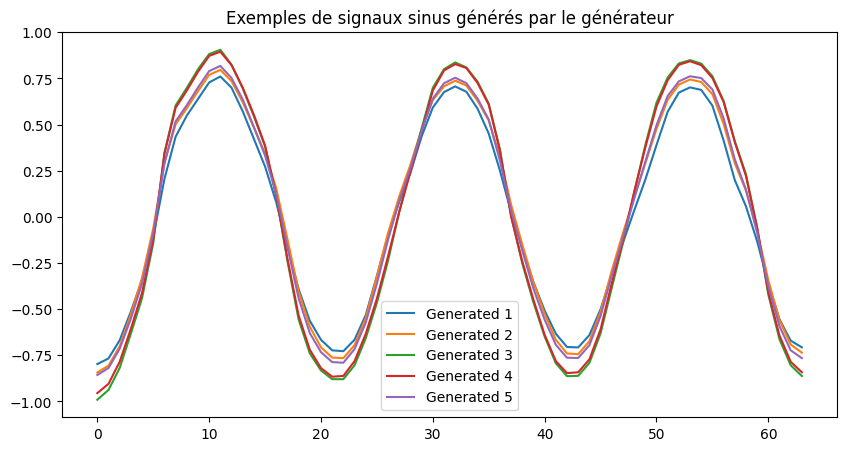

In [51]:
generator.eval()
with torch.no_grad():
    z = generate_noise(5, LATENT_DIM)
    samples = generator(z).cpu().numpy()

# On "dénormalise" pour l'affichage (optionnel, mais ici on reste normalisé)
# samples_denorm = samples * (std+1e-8) + mean

plt.figure(figsize=(10,5))
for i in range(5):
    plt.plot(samples[i], label=f"Generated {i+1}")
plt.title("Exemples de signaux sinus générés par le générateur")
plt.legend()
plt.show()

# Sauvegarde Modèle

In [52]:
# Créer le chemin de sauvegarde avec le nombre d'époques, la longueur des signaux et la date et l'heure
model_save_path = f"{OUTPUT_DIR}/ts_gan_transformer_epoch_{EPOCHS}_seq_len_{SEQ_LEN}_{current_time}.pth"

# Sauvegarder le modèle
torch.save({
    'generator_state_dict': generator.state_dict(),
    'discriminator_state_dict': discriminator.state_dict(),
    'g_optimizer_state_dict': optimizer_g.state_dict(),
    'd_optimizer_state_dict': optimizer_d.state_dict(),
}, model_save_path)

print("Modèle sauvegardé dans", model_save_path)

Modèle sauvegardé dans generated/generated_sinus_same_freq_phase_amp_seq_len_64_2024-12-09_16h25min/ts_gan_transformer_epoch_2000_seq_len_64_2024-12-09_16h25min.pth
